# Introduction to Statistical Learning

Authors: [Sam Foreman](https://samforeman.me)[^1], Taylor Childers, and Romit Maulik

This is a quick introduction to some statistical learning methods you may have encountered that will help us understand how modern deep learning methods operate.

[^1]: Presenter

# Running Jupyter Notebooks @ ALCF

## Polaris
**TODO**

## ThetaGPU
**TODO**

In [1]:
!echo $HOSTNAME
!which python3

x3002c0s31b0n0.cm.polaris.alcf.anl.gov
/soft/datascience/conda/2022-07-19/mconda3/bin/python3


## Import Python packages

Fortunately a lot of common data science tools are freely available in the python ecosystem (look at PyPi for details).

- [Scikit-learn](https://scikit-learn.org/stable/): `import sklearn`
- [Matplotlib](https://matplotlib.org/): `import matplotlib.pyplot as plt`, `import matplotlib as mpl`
- [Seaborn](https://seaborn.pydata.org/): `import seaborn as sns`

We can use `matplotlib` and `seaborn` for plotting data.

In [2]:
# automatically watch for local changes 
# and reload modules accordingly
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import IPython.display as ipydis
import time
import os

import numpy as np
import pandas as pd

import sklearn
from sklearn import datasets # Cancer dataset
from sklearn.preprocessing import (
    # Data processors
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.cluster import KMeans

from rich.console import Console
console = Console(log_path=False)

# set random seed for reproducibility
SEED = 42
DFIGSIZE = plt.rcParamsDefault['figure.figsize']

import atpesc
atpesc.__file__

'/lus/grand/projects/datascience/foremans/polaris/projects/ATPESC_MachineLearning/00_statisticalLearning/src/atpesc/__init__.py'

# Statistical Learning: Line Fitting

You are likely familiar with statistical learning in the form of linear regression so let's work through how we can fit linear data using a common learning method called [Stocastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD). SGD is a common method used in training deep neural networks. Here we will use it to fit linear data.

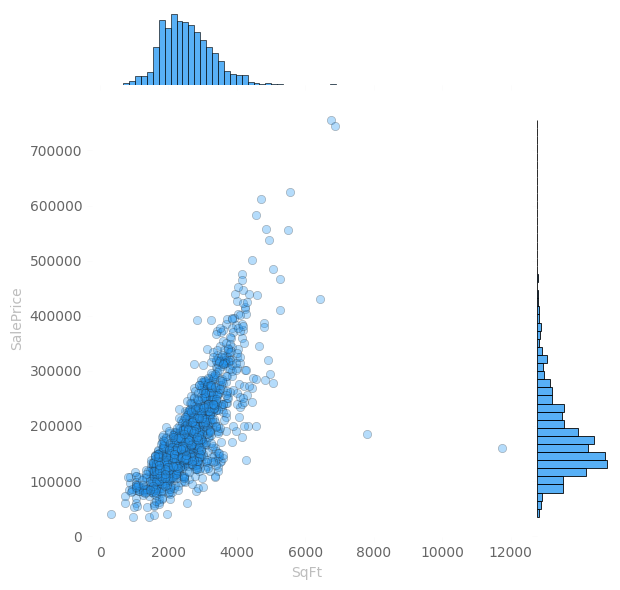

In [3]:
from pathlib import Path
from atpesc.common import DATA_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from atpesc.utils.plots import set_plot_style

import seaborn as sns
sns.set_context('notebook')

set_plot_style()
plt.rcParams['figure.figsize'] = DFIGSIZE

# ---------------------------------------------------------

data_file = Path(DATA_DIR).joinpath('realestate_train.csv')
assert data_file.is_file()
df = pd.read_csv(data_file)

# extract total home square footage
area = (
    df["1stFlrSF"]       # 1st floor sq. foot
    + df["2ndFlrSF"]     # 2nd floor sq. foot
    + df["TotalBsmtSF"]  # 3rd floor sq. foot
)
area.name = 'SqFt'
# and sale price
price = df["SalePrice"]

plot = sns.jointplot(
    x=area,
    y=price,
    edgecolor='#222222',
    alpha=0.33
)

The Data is nicely correlated as you might expect. Let's fit it with a line so we can estimate future sale prices based on home size. We'll assume our predition function is linear with a slope and a fixed zero intercept since no house size should be equal to zero sale price.

Now we need a way to evaluate how well our prediction fits the data and [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) is a common method used for our type of problem.

$$
\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2}
$$

In [4]:
def predict_price(linear_slope, input_area):
    return linear_slope * input_area

def evaluate(linear_slope,input_area,true_price):
    price_prediction = predict_price(linear_slope,input_area)
    MSE = np.mean((true_price - price_prediction)**2)
    return MSE

Our prediction will be based on a `linear_slope` that will be chosen at random at first, and we need to use our SGD to update it iteratively so it approaches the best value (the value that minimizes MSE). SGD uses this update policy:

$$
w := w - \eta\nabla Q(w) = w - \frac{\eta}{n}\sum_{i=1}^{n}\nabla Q_{i}(w)
$$

where in our case `w` is the slope we want to update and $\eta$ is called the "learning rate," and `Q(w)` is our prediction function. In our case this functionally looks like this:

In [5]:
def learn(
    input_area,
    input_price,
    input_slope,
    learning_rate=0.000001
):
    # first we need df/dx where f = predict_price and x = input_size
    df_dx = np.mean(2*(predict_price(input_slope,input_area) - input_price)*input_area)
    # now we update the slope 
    new_slope = input_slope - learning_rate * df_dx  # SGD update step
    return new_slope

## Stochastic Gradient Descent
Each application of the `learn` function updates the slope and the `learning_rate` dampens that update. This iterative method helps one find the value that minimizes the `df_dx`, or gradient, as shown below[^1].

The `learning_rate` is shown as driving how big of steps you take around the minimum. If your `learning_rate` is too large, you may miss the minimum, if it is too small you may never reach the minimum.

![sgd-example](https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/learning-rate.svg)

[^1]: [Image Reference](https://www.researchgate.net/publication/331758559_Synergy_of_physics-based_reasoning_and_machine_learning_in_biomedical_applications_Towards_unlimited_deep_learning_with_limited_data)

Putting it all together we can iterate to a solution:

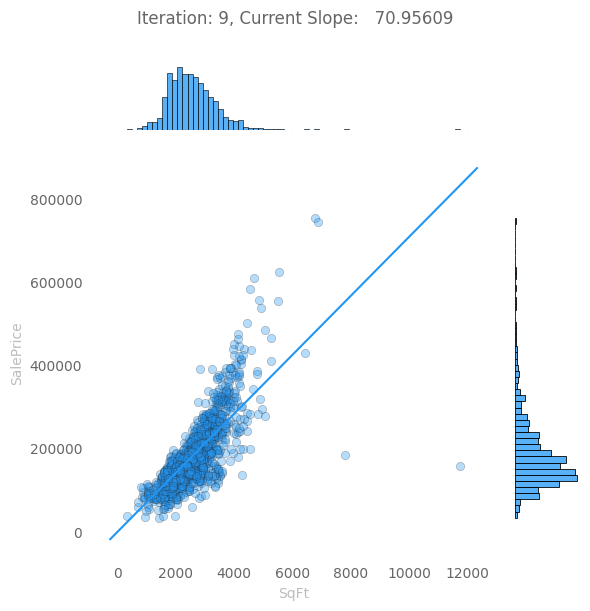

[14:09:11] Step: 9, Loss: 2463703099.22473, Current Slope:   70.95609

In [6]:
m = 1
learning_rate = 0.00000009  # play with this value
iterations = 10 
console.log("Initial slope: ", m)
slope_history = [m]
set_plot_style()
for i in range(0, iterations):
    m = learn(
        area,
        price,
        m,
        learning_rate
    )
    slope_history.append(m)
    # plot output so we can see progress
    ipydis.clear_output('wait')
    plot = sns.jointplot(
        x=area,
        y=price,
        alpha=0.33,
        edgecolor='#222222',
    )
    fig = plt.gcf()
    _ = fig.suptitle(f'Iteration: {i}, Current Slope: {m:10.5f}', y=1.01);
    xline = np.linspace(
        plot.ax_joint.axes.get_xlim()[0],
        plot.ax_joint.axes.get_xlim()[1],
        1000
    )
    yline = m * xline
    _ = plot.ax_joint.plot(xline, yline);
    _ = plt.tight_layout()
    _ = plt.show()
    
    loss = evaluate(m, area, price)
    console.log(
        f'Step: {i}, Loss: {loss:10.5f}, Current Slope: {m:10.5f}'
    )
    time.sleep(0.5)

We can visualize the slope history:

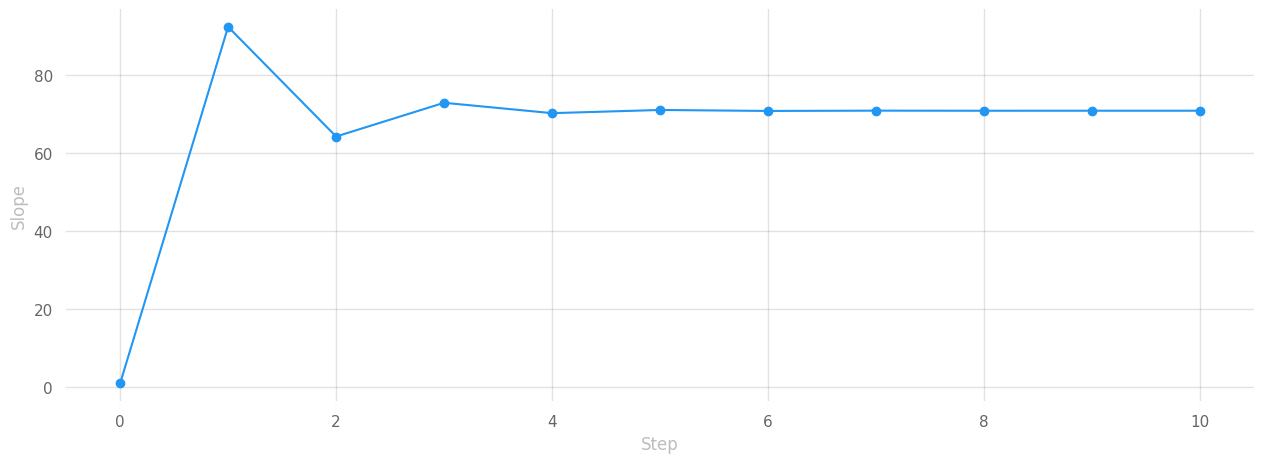

In [7]:
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(2*DFIGSIZE[0], DFIGSIZE[1]), tight_layout=True)
_ = ax.plot(range(len(slope_history)), slope_history, 'o-');
_ = ax.set_ylabel('Slope')
_ = ax.set_xlabel('Step')
_ = ax.grid(True, alpha=0.2)

# Learning to Cluster Data
Next we if have data with distinct groupings, the objective is to devise a method for labeling our data by its group in an automated way. We will demonstrate this, first, on a toy dataset that we _design_ to have a lower inherent dimensionality, then we move to a higher dimensional dataset.

## Toy dataset (2-D blobs)
Define 3 blobs of data on a 2D plane

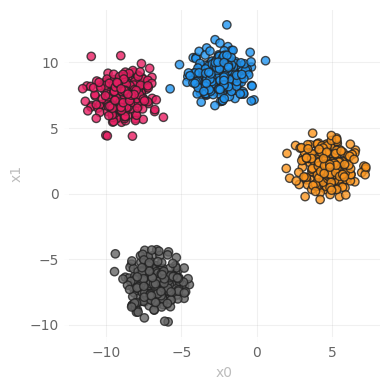

In [8]:
from matplotlib.colors import ListedColormap
from atpesc.utils.plots import scatter, COLORS

set_plot_style()
n_samples = 1000 # 300 2D data points
n_features = 2  # 2D data
n_clusters = 4  # 3 unique blobs

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
# -- Returns --------------------------------------------------------
# x (n_samples, n_features): The generated samples.
# y (n_samples,): Int labels for cluster membership of each sample.
# -------------------------------------------------------------------
cmap = ListedColormap(list(COLORS.values()))
x, y = datasets.make_blobs(n_samples=n_samples,
                           n_features=n_features,
                           centers=n_clusters,
                           random_state=SEED)
scatter_kwargs = {
    'xlabel': 'x0',
    'ylabel': 'x1',
    'cmap': cmap,
    'plot_kwargs': {
        'alpha': 0.8,
        'edgecolor': '#222',
    }
}
_ = scatter(x, y, **scatter_kwargs)

Normalizing the data features is always a good practice.

In [9]:
# Normalize features
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
x_sc = StandardScaler().fit_transform(x)

Plot the normalized data 

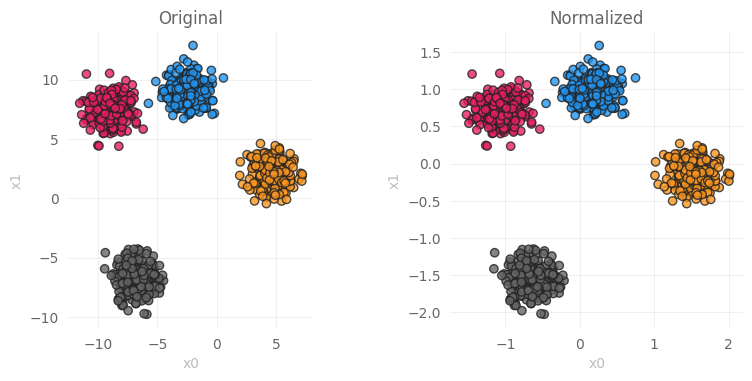

In [10]:
set_plot_style()
fig, (ax1, ax2) = plt.subplots(
    figsize=(1.5 * DFIGSIZE[0], 0.8 * DFIGSIZE[1]),
    ncols=2,
    subplot_kw={
        'aspect': 'equal',
    },
    
)
fig, ax1 = scatter(
    x,
    y,
    fig=fig,
    ax=ax1,
    title='Original',
    **scatter_kwargs
)
fig.subplots_adjust(wspace=0.2)
fig, ax2 = scatter(
    x_sc,
    y,
    fig=fig,
    ax=ax2,
    title='Normalized',
    **scatter_kwargs
)

## K-means Clustering

K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

1. Pick random starting centroids from data
    - $k$ initial "means" (in this case, $k = 3$) are randomly generated within the data domain (shown in color)
2. Calculate distance to each centroid
    - $k$ clusters are created by associating every observation with the nearest mean. The partitions here represent the Voroni diagram generated by the means
    - Find nearest cluster for each point
3. Calculate new centroids
    - The **centroid** of each of the $k$ clusters becomes the new mean
4. Steps 2 and 3 are repeated until convergence has been reached

<img alt="1" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step1.svg" width="24%" align="left">
<img alt="2" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step2.svg" width="24%" align="left">
<img alt="3" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step3.svg" width="24%" align="left">
<img alt="4" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step4.svg" width="24%" align="left">

### Step 1: Pick random starting centroids from data

- $k$ initial "means" (in this case, $k=3$) are randomly generated within the data domain (shown in color)

<img alt="1" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step1.svg" width="24%" align="center">

In [11]:
def initialize_centroids(
        x: np.ndarray,
        n_clusters: int,
        seed: int = 123
) -> np.ndarray:
    """Initialize centroids.
    
    Inputs:
      - x (np.ndarray): Data of shape (num_points, num_features)
      - n_clusters (int): Number of clusters to use
      - seed (int): Random seed.
        
    Outputs:
      - centroids (np.ndarray): Randomly chosen from the data
        with shape: (num_clusters, num_features).
    """
    np.random.RandomState(seed)
    # 1. Randomly permute data points
    # 2. From this, pick the first `n_clusters` indices
    # 3. Return these as our initial centroids
    random_idx = np.random.permutation(x.shape[0])
    centroids = x[random_idx[:n_clusters]]
    return centroids

### Step 2a: Calculate distance to each centroid

- Calculate distance to each centroid
    - $k$ clusters are created by associating every observation with the nearest mean. The partitions here represent the Voroni diagram generated by the means
    - Find nearest cluster for each point
    
<img alt="2" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step2.svg" width="24%" align="center">

In [12]:
def compute_distance(
        x: np.ndarray,
        centroids: np.ndarray,
        n_clusters: int
) -> np.ndarray:
    """Compute distance.
    
    Inputs:
      - x (np.ndarray): Input data of shape
        (num_points, num_features)
      - centroids (np.ndarray): Cluster centroids  with shape 
        (num_clusters, num_features)
      - n_clusters (int): Number of clusters being used.
        
    Outputs:
      - distance (np.ndarray): Distance of each point 
        to each centroid with shape 
        (num_points, num_clusters)
    """
    # distance vector
    distance = np.zeros((x.shape[0], n_clusters))
    # loop over each centroid
    for k in range(n_clusters):
        # calculate distance for each point from centroid
        kcentroid_distance = x - centroids[k, :]
        # apply normalization for stability
        row_norm = np.linalg.norm(kcentroid_distance, axis=1)
        # return distance squared
        distance[:, k] = np.square(row_norm) 
    
    return distance

### Step 2b: Find nearest cluster for each point

In [13]:
def find_closest_centroid(
        distance: np.ndarray
) -> np.ndarray:
    """Find closest centroid.
    
    Inputs:
      - distance (np.ndarray): Distance of each point to each centroid with shape
        (num_points, num_clusters)
            
    Outputs:
      - nearest_centroid_indices (np.ndarray): Index of nearest centroid with shape
        (num_points,)
    """
    nearest_centroid_indices = np.argmin(distance, axis=1)
    return nearest_centroid_indices

### Step 3: Calculate new centroids

3. Calculate new centroids
    - The **centroid** of each of the $k$ clusters becomes the new mean
    
<img alt="3" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step3.svg" width="24%" align="center">

In [14]:
def compute_centroids(
        x: np.ndarray,
        nearest_centroid_indices: np.ndarray,
        n_clusters: int
) -> np.ndarray:
    """Compute centroids.
    
    Inputs:
      - x (np.ndarray): Input data of shape
        (num_points, num_features)
      - nearest_centroid_indices: Index of nearest centroid of shape
        (num_points,)
      - n_clusters (int): Number of clusters being used
      
    Outputs:
      - centroids (np.ndarray): Cluster centroids with shape
        (num_clusters, num_features)
    """
    # new centroids vector
    centroids = np.zeros((n_clusters, x.shape[1]))
    # loop over each centroids
    for k in range(n_clusters):
        # calculate the mean of all points assigned to this centroid
        centroids[k, :] = np.mean(
            x[nearest_centroid_indices == k, :],
            axis=0
        )
    return centroids

### Step 4: Repeat until convergence

4. Steps 2 and 3 are repeated until convergence has been reached

<img alt="4" src="https://raw.githubusercontent.com/saforem2/ATPESC_MachineLearning/master/00_statisticalLearning/assets/atpesc-k-means-step4.svg" width="24%" align="center">

In [15]:
from __future__ import absolute_import, print_function, annotations, division
from typing import Optional
from atpesc.utils.plots import plot_kmeans_points

def apply_kmeans(
        x: np.ndarray,
        n_clusters: int,
        iterations: int = 100,
        seed: int = 123,
        cmap: Optional[str] = None,
) -> tuple[np.ndarray, np.ndarray]:
    """Returns (centroids, cluster_id)."""
    # ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
    # ┃ initialize centroids:               ┃
    # ┃   - shape: (n_clusters, x.shape[1]) ┃
    # ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
    centroids = initialize_centroids(
        x,  # (n_points, n_features)
        n_clusters=n_clusters,
        seed=seed
    )
    # ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
    # ┃ -- Iteratively improve centroid location ----------------- ┃
    # ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
    # ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
    # ┃ 1. Compute the distance from entries in x to each centroid ┃
    # ┃    - distance.shape: (n_points, n_clusters)                ┃
    # ┃ 2. Return the closest cluster (0, 1, ..., n_clusters-1)    ┃
    # ┃    - cluster_id.shape: (n_points)                          ┃
    # ┃ 3. Calculate the mean position of each labeled cluster     ┃
    # ┃    - centroids.shape: (n_clusters, n_features)             ┃
    # ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
    for i in range(iterations):
        # save old centroids
        old_centroids = centroids
        distance = compute_distance(x, old_centroids, n_clusters)
        cluster_id = find_closest_centroid(distance)
        centroids = compute_centroids(x, cluster_id, n_clusters)

        # plotting for visual comprehension
        ipydis.clear_output('wait')
        console.log(f'Iteration: {i}')
        plot_kmeans_points(x, centroids, cluster_id, cmap=cmap)
        time.sleep(0.5) 
        
        # if our points are the same as the old centroids, then we can stop
        if np.all(old_centroids == centroids):
            break 
        
    return centroids,cluster_id

### Run example:

[14:10:04] Iteration: 4

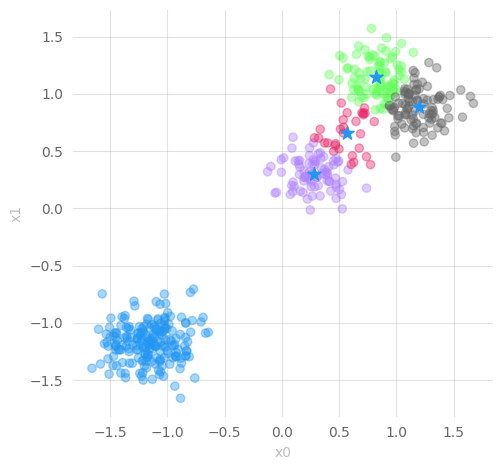

In [16]:
from atpesc.utils.plots import COLORS
cmap = ListedColormap(list(COLORS.values()))

n_samples = 500 # 300 2D data points
n_features = 2   # 2D data
n_clusters_true = 5   # unique blobs
n_clusters_guess = 5
SEED = 456
iterations = 50
set_plot_style()

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
x, y = datasets.make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters_true,
    random_state=SEED
)

x_sc = StandardScaler().fit_transform(x)

centroids, cluster_id = apply_kmeans(
    x_sc,
    n_clusters_guess,
    iterations,
    SEED,
    cmap=cmap,
)

# K-means on a breast cancer dataset

Now we use more realistic data that cannot be easily plotted on a 2D grid. This dataset has 30 features (columns) for 569 patients (rows). In addition, there is a _target_ feature that indicates if the cancer was _malignant_ (0) or _benign_ (1). In the ideal case, our 30 features would provide easy deliniation between these two classes.

Let's extract our data into $x$ and our truth labels into $y$

In [17]:
import pandas as pd

def load_cancer_data() -> dict:
    """Return cancer dataset (unscaled)."""
    from sklearn import datasets
    data = datasets.load_breast_cancer()
    return data

def sort_cancer_data(
        data: dict
) -> tuple[pd.DataFrame, pd.Series]:
    # Get features and target
    x = pd.DataFrame(
        data['data'],
        columns=data['feature_names'],
    )
    x = x[sorted(x.columns)]
    y = data['target']
    return x, y

In [18]:
data = load_cancer_data()
x, y = sort_cancer_data(data)

In [19]:
console.log(data.keys())
console.log('data size:',len(data['data']))
console.log('number of features:',len(data['feature_names']))
console.log(data['feature_names'])
# more information can be see by uncommenting this line:
# print(data['DESCR'])

[14:10:17] dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

           data size: 569

           number of features: 30

           ['mean radius' 'mean texture' 'mean perimeter' 'mean area'                                              
            'mean smoothness' 'mean compactness' 'mean concavity'                                                  
            'mean concave points' 'mean symmetry' 'mean fractal dimension'                                         
            'radius error' 'texture error' 'perimeter error' 'area error'                                          
            'smoothness error' 'compactness error' 'concavity error'                                               
            'concave points error' 'symmetry error' 'fractal dimension error'                                      
            'worst radius' 'worst texture' 'worst perimeter' 'worst area'                                          
            'worst smoothness' 'worst compactness' 'worst concavity'                                               
            'worst concave points' 'worst symmetry' 'worst fractal dimension']

Let's extract our data into $x$ and our truth labels into $y$

In [20]:
# wrap data in pandas DataFrame
# y = data['target'] # value: 0 = 'Malignant' 1 = 'Benign'
x = data['data']
y = data['target']
console.log(f'(malignant, benign): {np.bincount(y)}')
console.log(f'x.shape: {x.shape}')
console.log(f'y.shape: {y.shape}')

[14:10:22] (malignant, benign): [212 357]

           x.shape: (569, 30)

           y.shape: (569,)

Normalize our features by column:

In [21]:
# normalize
x_sc = StandardScaler().fit_transform(x)

Define K-means model and train, this time we'll just use the one from scikit-learn library. We use `n_clusters=2` since our target dataset has these two distinct classifications.

[14:10:27] seed: 42                                                                                                
           Number of samples in each cluster: [189 380]

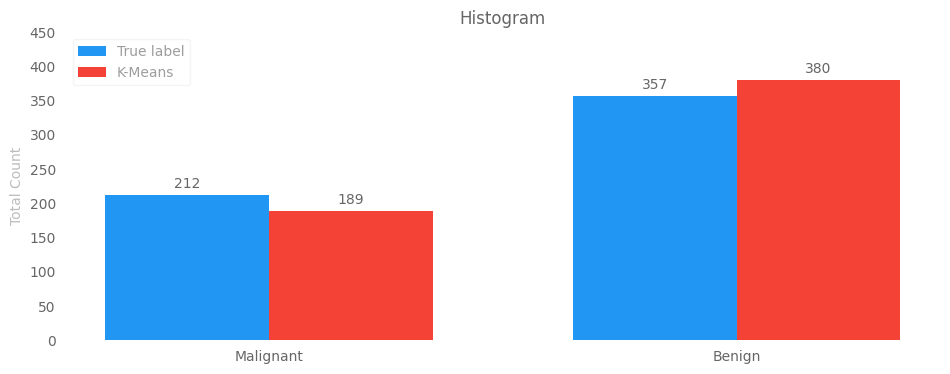

In [22]:
from atpesc.utils.plots import plot_hists

#for seed in range(10):
CSEED = 42
kmeans = KMeans(n_clusters=2, random_state=CSEED)
# fit the data
kfit = kmeans.fit(x_sc);
cluster_ids = kmeans.labels_
console.log(
    f'seed: {CSEED}\n'
    'Number of samples in each cluster: '
    f'{np.bincount(kmeans.labels_)}'
)
k_means_bins = np.bincount(cluster_ids)
y_bins = np.bincount(y)
plt.rcParams['figure.figsize'] = [
    1.5 * DFIGSIZE[0], 0.8 * DFIGSIZE[1]
]
plot_hists(
    k_means_bins,
    y_bins,
    xlabels=['Malignant', 'Benign']
)

Plot histogram of number of true class labels (malignant/benign) and number of k-means cluster labels. This gives an indication of how well we did in clustering our data, but is not a "correctness" or "accuracy" metric. Keep in mind, k-means is not a classifier. Cluster label 0 given from k-means, does not correspond to cluster label 0 in the truth.

This plot shows the normalized inertia as we vary the number `n_clusters` used in our k-means fit to the breast cancer data. This value essentially indicates the mean distance of a point to the cluster centroids. Obviously more clusters result in data points being nearer to a centroid. If our dataset easily split into 2 clusters, we would see a step function behavior going from 1 to 2, then only very minor improvements above 2. What we see here tells us our data does not easily cluster.

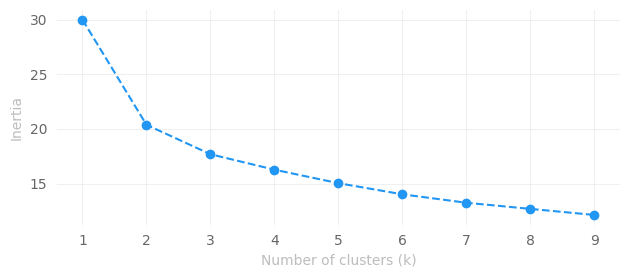

In [23]:
from atpesc.utils.plots import plot_kmeans_obj

set_plot_style()
plt.rcParams['figure.figsize'] = [DFIGSIZE[0], 0.6 * DFIGSIZE[1]]
_ = plot_kmeans_obj(x_sc, nclusters=10, plot_points=False)

For example, if we return to our blob data with 2 clusters, it become clear.

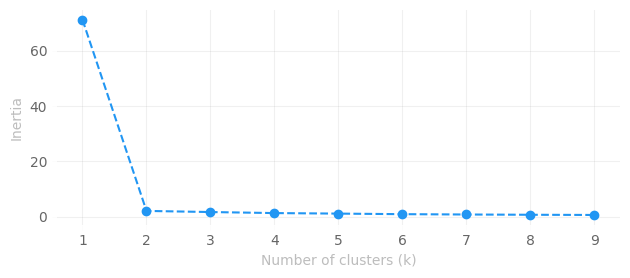

In [24]:
n_samples  = 300 # 300 2D data points
n_features = 2   # 2D data
n_clusters = 2   # unique blobs
seed       = 456
iterations = 25
x, y = datasets.make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=seed
)
plot_kmeans_obj(x, nclusters=10, plot_points=False);

# [Self-organizing maps](https://en.wikipedia.org/wiki/Self-organizing_map)

Self Organizing Maps (SOM) were proposed and became widespread in the 1980s, by a Finnish professor named Teuvo Kohonen and are also called 'Kohonen maps'.

The idea behind a SOM is that you’re mapping high-dimensional vectors onto a smaller dimensional (typically 2D) space. Vectors that are close in the high-dimensional space also end up being mapped to nodes that are close in 2D space thus preserving the "topology" of the original data.

In [25]:
# finding best matching unit
def find_bmu(t, net, n):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    #min_dist = #np.iinfo(np.int).max
    min_dist = np.inf
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(n, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(n, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

# Decaying radius of influence 
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

# Decaying learning rate
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

# Influence in 2D space
def calculate_influence(distance, radius):
    return np.exp(-distance / (2. * (radius**2)))

# Update weights
def update_weights(net,bmu_idx,r,l):
    wlen = net.shape[2]
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(wlen, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, wlen)
    return net

### Generating "Color" data and normalizing

In [26]:
raw_data = np.random.randint(0, 255, (10000, 3)) # JPEG like data
#raw_data = np.random.uniform(size=(500, 3))
data = StandardScaler().fit_transform(raw_data) # Normalized

### Defining SOM 
Defining network size, number of iterations and learning rate

In [27]:
network_dimensions = np.array([50, 50])
n_iterations = 2500
init_learning_rate = 0.075

Establish size variables based on data

In [28]:
m = data.shape[0]
n = data.shape[1]

Weight matrix (i.e. the SOM) needs to be one n-dimensional vector for each neuron in the SOM

In [29]:
net = np.random.random((network_dimensions[0], network_dimensions[1], n)) # 25 neurons each with a 3D vector

Initial neighbourhood radius and decay parameter

In [30]:
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2.
time_constant = n_iterations / np.log(init_radius)

### Initial state of SOM color network

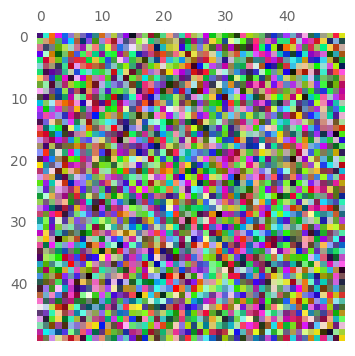

In [31]:
set_plot_style()
plt.rcParams['image.cmap'] = 'rainbow'
fig, ax = plt.subplots(figsize=(4, 4))
image = ax.matshow(net)
#_ = fig.colorbar(image)
_ = plt.show()

### Training SOM

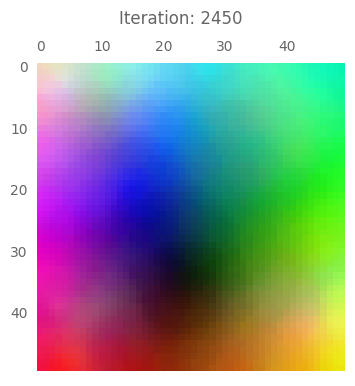

In [32]:
def normalize(x: np.ndarray) -> np.ndarray:
    return (x - np.min(x)) / (np.max(x) - np.min(x))

set_plot_style()
plt.rcParams['figure.figsize'] = [
    i / 2.0
    for i in plt.rcParamsDefault['figure.figsize']
]
init_learning_rate=0.1
#net = np.random.uniform(size=net.shape)
#net = (255 * ((net + 1.) / 2.))
images = []
for iteration in range(n_iterations):
    # select a training example at random - shape of 1x3
    t = data[np.random.randint(0, m),:].reshape(np.array([n, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n) # Gives the row, column of the best neuron
    # decay the SOM parameters
    r = decay_radius(init_radius, iteration, time_constant)
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    # Update SOM weights
    net = update_weights(net,bmu_idx,r,l)
    if iteration % 50 == 0:
        console.log(f'Iteration: {iteration}')
        ipydis.clear_output('wait')
        fig, ax = plt.subplots(figsize=(4, 4))
        net_img = normalize(net)
        _ = fig.suptitle(f'Iteration: {iteration}', y=1.0);
        plt.tight_layout()
        image = ax.matshow(net_img, cmap='rainbow')
        if iteration % 100 == 0:
            images.append(net_img)
        _ = plt.show()
        time.sleep(0.5)

### Visualization of trained colormap SOM

In [33]:
len(images)

25

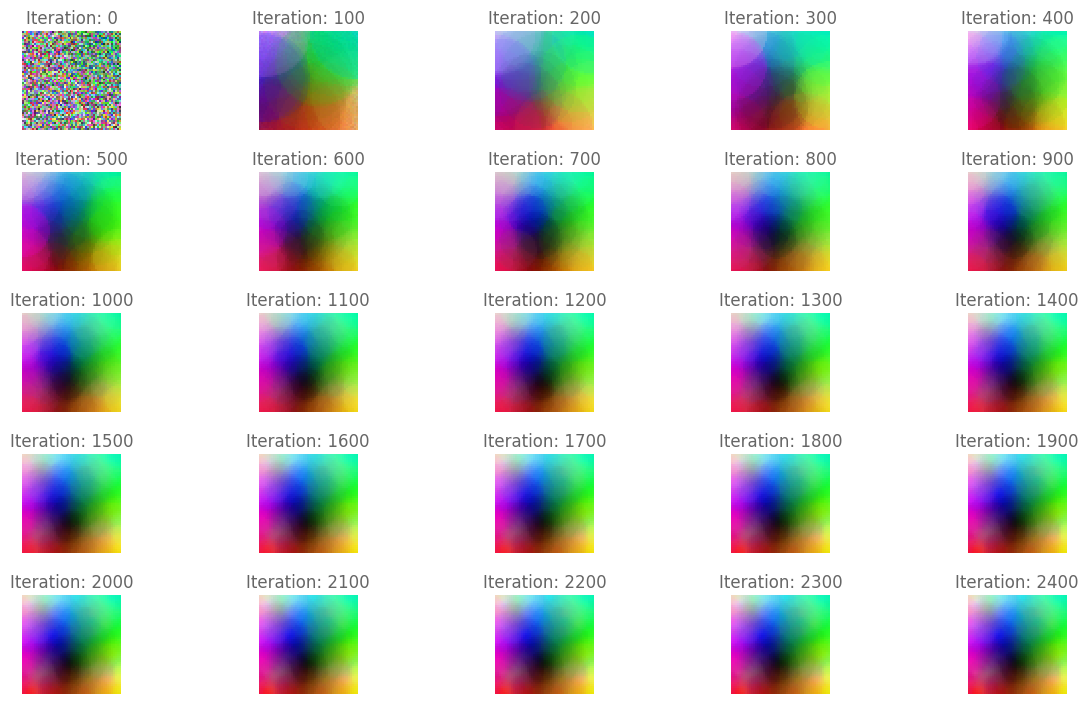

In [34]:
fig, axes = plt.subplots(
    figsize=(2. * DFIGSIZE[0], 1.5 * DFIGSIZE[1]),
    nrows=5,
    ncols=5,
    tight_layout=True,
)
fig.subplots_adjust(wspace=0.1)
axes = axes.flatten()
for idx, (img, ax) in enumerate(zip(images, axes)):
    _ = ax.matshow(img, cmap='rainbow');
    _ = ax.set_title(f'Iteration: {100 * idx}')
    _ = ax.set_xticks([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_yticklabels([])
    
_ = plt.show();

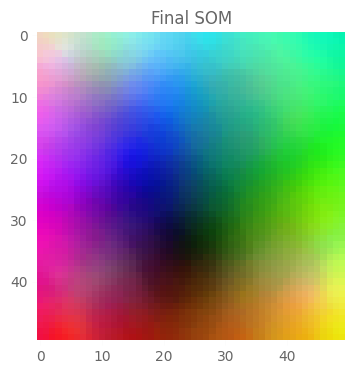

In [35]:
from matplotlib import cm
fig, ax = plt.subplots(figsize=(4, 4))
image = ax.imshow(normalize(net), cmap='rainbow');
_ = ax.set_title('Final SOM')
_ = plt.show();

### 1.3.5 SOM on Cancer data

In [36]:
# Load data
data = datasets.load_breast_cancer()
# Get features and target
X = data['data'] # pd.DataFrame(data['data'], columns=data['feature_names'])
Y = data['target']
console.log(X.shape,Y.shape)

[14:50:59] (569, 30)                                                                                               
           (569,)

In [37]:
network_dimensions = np.array([10, 10])
n_iterations = 2000
init_learning_rate = 0.01
# establish size variables based on data
n_points = X.shape[0] # number of points
n_features = X.shape[1] # 30 features per point

# weight matrix (i.e. the SOM) needs to be one n-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], n_features))

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

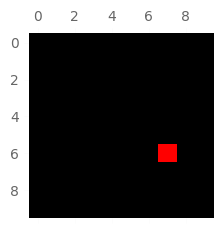

In [38]:
# convert the network to something we can visualize 
net_vis = np.zeros(
    shape=(net.shape[0], net.shape[1], 3),
    dtype=np.float32,
) # Array for SOM color map visualization

for sample in range(n_points):
    t = X[sample,:].reshape(np.array([n_features, 1]))
    # find its Best Matching Unit for this data point
    bmu, bmu_idx = find_bmu(t, net, n_features)
    # set that unit to the label of this data point
    net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign


fig, ax = plt.subplots()
im = ax.matshow(normalize(net_vis))
#_ = plt.colorbar(im1, ax=ax1)
plt.show()

### Training SOM on Cancer data

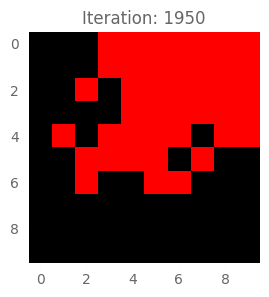

In [39]:
for iteration in range(n_iterations):
    # select a training example at random - shape of 1x3
    t = X[np.random.randint(0, n_points),:].reshape(np.array([n_features, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n_features)
    # decay the SOM parameters
    r = decay_radius(init_radius, iteration, time_constant)
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    # Update SOM weights
    net = update_weights(net,bmu_idx,r,l)

    if iteration % 50 == 0:
        ipydis.clear_output('wait')
        net_vis = np.zeros(shape=(np.shape(net)[0],np.shape(net)[1],3),dtype='double') # Array for SOM color map visualization 
        for sample in range(n_points):
            t = X[sample,:].reshape(np.array([n_features, 1]))
            # find its Best Matching Unit
            bmu, bmu_idx = find_bmu(t, net, n_features)
            net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign 
            
        fig, ax = plt.subplots(figsize=(3, 3))
        _ = ax.set_title(f'Iteration: {iteration}')
        _ = ax.imshow(normalize(net_vis), cmap='rainbow')
        _ = plt.show();
        time.sleep(0.25)

### Visualization of trained SOM

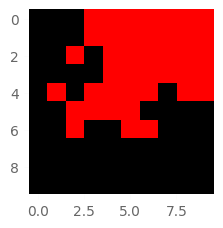

In [40]:
net_vis = np.zeros(shape=(net.shape[0],net.shape[1],3),dtype='double') # Array for SOM color map visualization

for sample in range(n_points):
    t = X[sample,:].reshape(np.array([n_features, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n_features)
    net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign
    
_ = plt.imshow(normalize(net_vis));
_ = plt.show();

# Keep learning

1. lagunita.stanford.edu/courses/HumanitiesSciences/StatLearning/Winter2016/course/
2. www.coursera.org/learn/ml-clustering-and-retrieval/
3. www.coursera.org/learn/machine-learning/home/week/8